In [1]:
import os
import time
import sys
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import NearestCentroid, kneighbors_graph
from sklearn import metrics
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy.spatial import KDTree, cKDTree
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from concorde.tsp import TSPSolver
from math import sqrt, ceil, inf, floor

In [2]:
root_dir = os.getcwd()
tsp_dir = os.path.join(root_dir, "../tsplib")
print(tsp_dir)
concorde_dir = os.path.join(root_dir, "../pyconcorde/concorde")

/home/min/a/aholla/Desktop/MACIsing/Large-Scale-Ising/../tsplib


In [3]:
sys.path.insert(0, root_dir)
sys.path.insert(0, tsp_dir)
#sys.path.insert(0, concorde_dir)

In [4]:
num_samples = 10000

In [5]:
def gen_tsp_data():
    ## Load a tsp library and Create a dictionary "tsp_database" of Name-X/Y coordinates.

    tsp_database = {}
    cities = os.listdir(tsp_dir)
    
    for city in cities:
        if city.endswith(".tsp"):
            with open(tsp_dir + '/' + city, 'r') as infile:
                lines = infile.readlines()
                for i in range(0, len(lines)):
                    line = lines[i]
                    if "DIMENSION" in line:
                        Dimension = line.strip().split(':')[1]
                        if not Dimension.isdigit():
                            continue
                    if "EDGE_WEIGHT_TYPE" in line:
                        EdgeWeightType = line.strip().split()[1]
                        if EdgeWeightType != "EUC_2D":
                            continue
                    if "NODE_COORD_SECTION" in line:
                        x_y = None
                        nodelist_x = []
                        nodelist_y = []
        
                        for j in range (1, int(Dimension)):
                            x_y = lines[i+1].strip().split()[1:]
    #                        print(x_y)
    #                        import pdb; pdb.set_trace()
                            x = x_y[0]
                            y = x_y[1]
                            nodelist_x.append(float(x))
                            nodelist_y.append(float(y))
                            i+=1
                        tsp_database.update({city[:-4]:[nodelist_x, nodelist_y]})
    return tsp_database    

In [6]:
tsp_database = gen_tsp_data()
problem_list = tsp_database.keys()
problem_list

dict_keys(['a280', 'ali535', 'att48', 'att532', 'berlin52', 'bier127', 'brd14051', 'burma14', 'ch130', 'ch150', 'd1291', 'd15112', 'd1655', 'd18512', 'd198', 'd2103', 'd493', 'd657', 'dsj1000', 'eil101', 'eil51', 'eil76', 'fl1400', 'fl1577', 'fl3795', 'fl417', 'fnl4461', 'gil262', 'gr137', 'gr202', 'gr229', 'gr431', 'gr666', 'gr96', 'kroA100', 'kroA150', 'kroA200', 'kroB100', 'kroB150', 'kroB200', 'kroC100', 'kroD100', 'kroE100', 'lin105', 'lin318', 'linhp318', 'nrw1379', 'p654', 'pcb1173', 'pcb3038', 'pcb442', 'pla33810', 'pla7397', 'pla85900', 'pr1002', 'pr107', 'pr124', 'pr136', 'pr144', 'pr152', 'pr226', 'pr2392', 'pr264', 'pr299', 'pr439', 'pr76', 'rat195', 'rat575', 'rat783', 'rat99', 'rd100', 'rd400', 'rl11849', 'rl1304', 'rl1323', 'rl1889', 'rl5915', 'rl5934', 'st70', 'ts225', 'tsp225', 'u1060', 'u1432', 'u159', 'u1817', 'u2152', 'u2319', 'u574', 'u724', 'ulysses16', 'ulysses22', 'usa13509', 'vm1084', 'vm1748'])

Problem : gil262


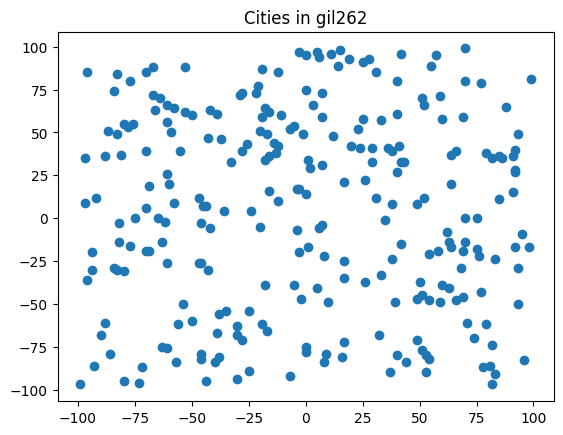

In [8]:
import pyproj as p

x = "gil262"

coord_geo = False
if coord_geo == True:
     crs_wgs = p.Proj(init='epsg:4326')
     crs_bng = p.Proj(init = 'epsg:27700')
    
     tsp_database[x][0],tsp_database[x][1]  = p.transform(crs_wgs, crs_bng, tsp_database[x][1], tsp_database[x][0])
# for x in tsp_database:
print("Problem : " + x)
#    print(tsp_database[x])
X_coord = np.array(tsp_database[x][0])
Y_coord = np.array(tsp_database[x][1])
X_Y = np.array(list(zip(X_coord,Y_coord))).reshape(len(X_coord),2)
plt.plot()
plt.title('Cities in ' + x)
plt.scatter(X_coord, Y_coord)
plt.show()


lt.plot()<br>
lt.title('Cities in ' + x)<br>
lt.scatter(X_coord, Y_coord)<br>
lt.show()

In [12]:
from numpy import inf

X_Y[X_Y == inf] = 0

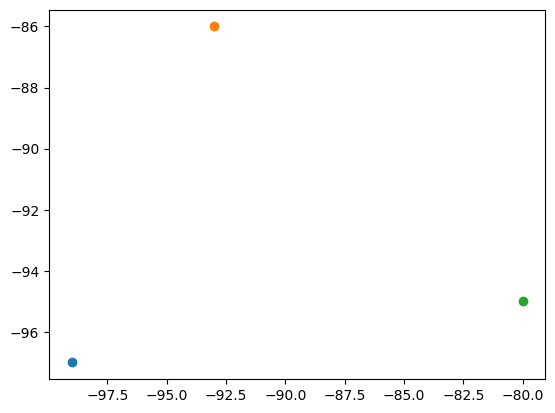

In [15]:
def nearest_two_points(X_Y):
    # for each point in X_Y, find the nearest 2 points.
    distances = np.linalg.norm(X_Y[:, np.newaxis, :] - X_Y[np.newaxis, :, :], axis=-1)

    # For each point, find the indices of the 2 smallest non-zero distances
    closest_points = []
    for i in range(len(X_Y)):
        # Exclude the point itself by setting its distance to infinity
        distances[i, i] = np.inf
        # Get the indices of the 2 closest points
        closest_indices = np.argsort(distances[i])[:2]
        closest_points.append(closest_indices)

    closest_points = np.array(closest_points)

    return closest_points

4


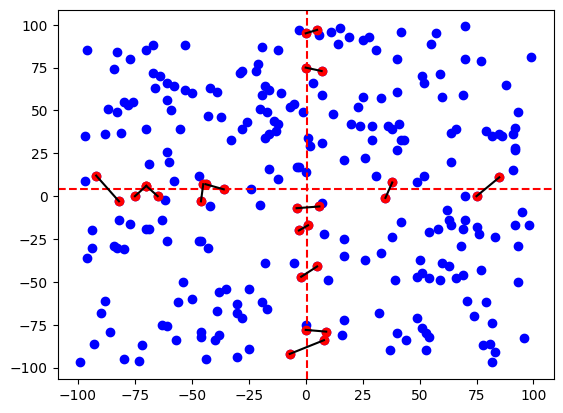

In [140]:
def generate_transit_points(X_Y, ising_size = 12):
    '''
    Splits the grid of given points into 4 (vertical line parallel to y-axis, and a horizontal line parallel to x-axis), and generates
    transit points between the 4 quadrants.
    The logic for whether a point is a transit point is as follows:
    After splitting the graph, calculate the distance to the closest 2 points. If one of the points is in the other quadrant, then it is a transit point.
    Make sure number of transit points are even.
    
    transit points is a list (np array) that contains a list/np.array of links [p1, p2] between quadrants (p1 and p2 are indices in X_Y)
    '''
    # Find the midpoint of the graph along x and y axis
    x_mid = np.mean(X_Y[:,0])
    y_mid = np.mean(X_Y[:,1])

    #Split the graph into 4 quadrants, give an ID to each point based on which quadrant it belongs to.
    quadrant_id = np.zeros(len(X_Y))
    
    quadrant_id[(X_Y[:,0] > x_mid) & (X_Y[:,1] > y_mid)] = 1
    quadrant_id[(X_Y[:,0] < x_mid) & (X_Y[:,1] > y_mid)] = 2
    quadrant_id[(X_Y[:,0] < x_mid) & (X_Y[:,1] < y_mid)] = 3
    quadrant_id[(X_Y[:,0] > x_mid) & (X_Y[:,1] < y_mid)] = 4
    
    # Find the closest 2 points for each point
    closest_points = nearest_two_points(X_Y)
    
    #For each point in X_Y, check if the closest 2 points are in the same quadrant or not.
    #If not, then it is a transit point.
    transit_points = []
    point_freq = {}
    for i in range(len(X_Y)):
        p1 = p2 = -1
        if quadrant_id[closest_points[i][0]] != quadrant_id[i] or quadrant_id[closest_points[i][1]] != quadrant_id[i]:
            p1 = i
            if i in point_freq:
                point_freq[i] += 1
            else:
                point_freq[i] = 1
            #identify if the closest or second closest is in the other quadrant
            if quadrant_id[closest_points[i][0]] != quadrant_id[i]:
                p2 = closest_points[i][0]
                if closest_points[i][0] in point_freq:
                    point_freq[closest_points[i][0]] += 1
                else:   
                    point_freq[closest_points[i][0]] = 1
            elif quadrant_id[closest_points[i][1]] != quadrant_id[i]:
                if closest_points[i][1] in point_freq:
                    point_freq[closest_points[i][1]] += 1
                else:
                    point_freq[closest_points[i][1]] = 1
                p2 = closest_points[i][1]
        if p1 != -1 and p2 != -1:
            if [p2, p1] not in transit_points:
                transit_points.append([p1, p2])
            else:
                point_freq[p1] -= 1
                point_freq[p2] -= 1
    #Remove duplicates from the transit points list
    #transit_points = list(set(transit_points))
    #Remove extraneous transit points, re-iterate through current transit points list
    #If the closest 2 points of a transit point are also transit points, keep the one that is closer to the point in the opposite quadrant.
    
    transit_points = np.array(transit_points)
    for k, v in point_freq.items():
        flag = 0
        if v > 2:
            #cut out all except the shortest 2 links
            l = np.array([subarray for subarray in transit_points if k in subarray])
            l_distances = [np.linalg.norm(X_Y[r[0], :] - X_Y[r[1], :]) for r in l]
            indices_to_keep = np.argsort(l_distances) < 2
            deletions = l[~indices_to_keep]
            unique, counts = np.unique(deletions, return_counts=True)
            for value, count in zip(unique, counts):
                if value in point_freq:
                    point_freq[value] -= count
            mask = ~np.any(np.all(transit_points[:, None] == deletions, axis=2), axis=1)
            transit_points = transit_points[mask]
            flag = 1
        elif v == 2 or flag == 1:
            #if the trio is numbered as (1, 2) (3), then remove the longer link between 13 or 23 only if d13+d23 > d12 + min(d13, d23)
            l = np.array([subarray for subarray in transit_points if k in subarray])
            common_index = np.intersect1d(l[0], l[1])
            all_indices = np.union1d(l[0], l[1])
            other_indices = np.setdiff1d(all_indices, common_index)
            
            d13 = np.linalg.norm(X_Y[common_index[0], :] - X_Y[other_indices[0], :])
            d23 = np.linalg.norm(X_Y[common_index[0], :] - X_Y[other_indices[1], :])
            d12 = np.linalg.norm(X_Y[other_indices[0], :] - X_Y[other_indices[1], :])
            
            if d13 + d23 > d12 + min(d13, d23):
                if d13 < d23:
                    #remove link 23
                    deletions = [subarray for subarray in l if other_indices[1] in subarray]
                    unique, counts = np.unique(deletions, return_counts=True)
                    for value, count in zip(unique, counts):
                        if value in point_freq:
                            point_freq[value] -= count
                    mask = ~np.any(np.all(transit_points[:, None] == deletions, axis=2), axis=1)
                    transit_points = transit_points[mask]
                else:
                    #remove link 13
                    deletions = [subarray for subarray in l if other_indices[0] in subarray]
                    unique, counts = np.unique(deletions, return_counts=True)
                    for value, count in zip(unique, counts):
                        if value in point_freq:
                            point_freq[value] -= count
                    mask = ~np.any(np.all(transit_points[:, None] == deletions, axis=2), axis=1)
                    transit_points = transit_points[mask]
    
    #Group all points into the 4 quadrants, make a tuple of points, transit points for each quadrant. return as a list of tuples.
    partitions = []
    for i in range(1, 5):
        xq = X_Y[quadrant_id == i]
        partitions.append(xq)
    tps_partitioned = [[] for _ in range(4)]
    for p1, p2 in transit_points:
        q1 = quadrant_id[p1]
        q2 = quadrant_id[p2]
        tps_partitioned[int(q1-1)].append([p1, p2])
        tps_partitioned[int(q2-1)].append([p2, p1])
        
    #Check if a quadrant is Ising solvable. Number of points < max_ising_size and number of transit points = 2
    ising_validation_list = []
    for i in range(4):
        ising_solvable = False
        if len(partitions[i]) < ising_size and len(tps_partitioned[i]) <= 2:
            ising_solvable = True
        ising_validation_list.append(ising_solvable)
            
    
    coords_partitions_list = list(zip(partitions, tps_partitioned, ising_validation_list))
    print(len(ising_validation_list))                          
    return coords_partitions_list, transit_points, x_mid, y_mid
    
    
pl, tp, x_mid, y_mid = generate_transit_points(X_Y)

plt.scatter(X_Y[:,0], X_Y[:,1], c='b')
plt.axhline(y=y_mid, color='r', linestyle='--')
plt.axvline(x=x_mid, color='r', linestyle='--')
#plt.scatter(X_Y[tp,0], X_Y[tp,1], c='r')
for p1, p2 in tp:
    x_coords = [X_Y[p1, 0], X_Y[p2, 0]]
    y_coords = [X_Y[p1, 1], X_Y[p2, 1]]
    plt.scatter(x_coords, y_coords, c='r')
    plt.plot(x_coords, y_coords, color='black')


In [1857]:
## sys2_cities has [hierarchies where the sub-cluster belongs, Center X/Y coordinates of the sub-cluster, Cities X/Y coordinates in the sub-cluster]
## sys2_centers has [hierarchies where the sub-cluster belongs, Center X/Y coordinates of the sub-cluster]
## sys2_clusters has [hierarchies where the sub-cluster belongs, Cities X/Y coordinates in the sub-cluster]
sys2_centers = []
sys2_clusters = []

H = range(0,len(hierarchies))
for h in H:
    K = range(0,hierarchies[h])
    sys2_centers.append([])
    sys2_clusters.append([])
    colors = mpl.cm.tab20(range(20))
    for k in K:
        sys2_centers[h].append(X_Y[h+1][k])
        sys2_clusters[h].append(X_Y[h][get_clustered_cities(k, KM_labels[h])])
    largest_cluster_size = 0
    smallest_cluster_size = 100
    for k in K:
        if len(sys2_clusters[h][k]) > largest_cluster_size:
            largest_cluster_size = len(sys2_clusters[h][k])
        if len(sys2_clusters[h][k]) < smallest_cluster_size:
            smallest_cluster_size = len(sys2_clusters[h][k])
        if (len(sys2_clusters[h][k]) == 1):
            print("dirty cluster")
    print("The largest & smallest cluster size in Hierarchy ",h+1, ": ", largest_cluster_size, " & ", smallest_cluster_size)
## Add the topmost cluster
sys2_centers.append([])
sys2_clusters.append([])
sys2_centers[-1].append([0, 0])
sys2_clusters[-1].append(X_Y[-1])

dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty 

In [1858]:
def Fix_first_last_cities(sys2_centers, sys2_clusters, sol_route, Lowest_Hier):
    ## Find a pair of the closest cities, each of which is in a distinct cluster which will be sequentially visited.
    ## After finding, place each city of the pair in the end of the preceding cluster and the start of the following cluster.
    ## To avoid the city in the following cluster to be selected once again for the next search, the next search starts from Index 1.
    ## Refer to Page 25
    tree = cKDTree(sys2_centers)
    clust_id_list = []
    total_traveling_distance = 0
    
    for k in range(len(sol_route)-1):
        ## Finding a pair of cities from distinct sub-clusters having the shortest distance betweeen sub-clusters.
        clust_idx_curr = tree.query(sol_route[k])[1]
        clust_idx_next = tree.query(sol_route[k+1])[1]
        if k ==0:
            clust_id_list.append(clust_idx_curr)
        clust_id_list.append(clust_idx_next)
        
        curr_clust = sys2_clusters[clust_idx_curr]
        next_clust = sys2_clusters[clust_idx_next]
        tree_clust = cKDTree(next_clust)
        ## For the first cluster in a hierarchy, all cities in the cluster is included in the search.
        ## For clusters that include only one city, the city that has been chosen for the first city from the previous search 
        ## will be used for the search and chosen for the last city. The first and last city at the same time. 
        if k ==0 or len(curr_clust) == 1:
            search_init = 0
        ## Otherwise, the first city is excluded from the search, because it's already chosen for the first city.
        else:
            search_init = 1
        sht_dist = inf
        for inc in range(search_init, len(curr_clust)):
            val_sd, idx_sd = tree_clust.query(curr_clust[inc])
            if val_sd < sht_dist:
                sht_dist = val_sd
                sht_idx_curr = inc
                sht_idx_next = idx_sd
                
        ## Fix the first and the last cities according to the information found above, unless the clust has one city.
        if len(curr_clust) > 1:
            curr_clust[[-1, sht_idx_curr]] = curr_clust[[sht_idx_curr,-1]]
            sys2_clusters[clust_idx_curr] = curr_clust
        if len(next_clust) > 1:
            next_clust[[0, sht_idx_next]] = next_clust[[sht_idx_next,0]]
            sys2_clusters[clust_idx_next] = next_clust
        if Lowest_Hier:
            total_traveling_distance += sht_dist
            #print("Inter-cluster distance (clusters ", k, "-", k+1, "): ", sht_dist, " total distance: ", total_traveling_distance)
            
    return sys2_clusters, clust_id_list, total_traveling_distance

In [1859]:
def skip_ising(Lowest_Hier, hier, total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array, curr_clust_size, infile, outfile):
    #print("Ising skipped!!")
    timet[-1].append(0)
    nMAC_array[-1].append(0)
    nRandFlip_array[-1].append(0)
    DIST = 0
    with open(infile,"r") as inF:
        lines = inF.readlines()
        outF = open(outfile,"w")
        
        for i in range(1, curr_clust_size+1):
            line = lines[i]
            outF.write(line)
            
            curr = line.strip().split()
            for j in range(len(curr)):
                curr[j] = float(curr[j])
            sol_route.append(curr)
            
            '''
            if Lowest_Hier:
                if (i == 1):
                    route_btw_clusters.append(curr)
                if (i == curr_clust_size):
                    route_btw_clusters.append(curr)
            '''
            if (i == 1):
                    route_btw_clusters[hier].append(curr)
            if (i == curr_clust_size):
                    route_btw_clusters[hier].append(curr)
        if curr_clust_size == 1:
            DIST = 0
        else:
            for i in range(1, curr_clust_size):
                X1 = float(lines[i].strip().split()[0])
                Y1 = float(lines[i].strip().split()[1])
                X2 = float(lines[i+1].strip().split()[0])
                Y2 = float(lines[i+1].strip().split()[1])
                DIST += sqrt((X1-X2)**2+(Y1-Y2)**2)
        outF.write("\n")
        outF.write("dist ")
        outF.write(str(DIST))
        outF.write("\n")
        outF.write("n_MAC 0")
        outF.write("\n")
        outF.write("n_RandFlip 0")
        outF.write("\n")
        
        outF.close()
        inF.close()

        if Lowest_Hier:
            total_traveling_distance += DIST
    
    return total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array

In [1860]:
def gen_sys2_sol(MAC_ising, benchmark, sys2_centers, sys2_clusters, SchPar):
    MAC_ising = True
    if MAC_ising:
        cpp_cmd = "./ising_mac3"
    else :
        cpp_cmd = "./ising_RNG"
    os.system("rm -rf sys2clusters_" + str(benchmark))
    SYS2_CENTERS = sys2_centers
    SYS2_CLUSTERS = sys2_clusters
    
    timet =[]
    nMAC_array =[]
    nRandFlip_array = []
    sys2_labels = []
    colors = mpl.cm.tab20(range(20))
    sol_route = 0
    sol_route_ex = []
    
    ideal_latency = 0
    nMAC_hierarchies = []
    route_btw_clusters = [[] for _ in range(n_hierarchies+1)]
  
    for h in range(0, n_hierarchies+1):
        print("Execute Ising Solver for Hierarchy ", n_hierarchies-h)
        sys2_centers = SYS2_CENTERS[n_hierarchies-h]
        sys2_clusters = SYS2_CLUSTERS[n_hierarchies-h]

        if h != 0:
            tic = time.perf_counter()
            sys2_clusters, clust_id_list, total_traveling_distance = Fix_first_last_cities(sys2_centers, sys2_clusters, sol_route, h == n_hierarchies)
            toc = time.perf_counter()
            print("Fixing time:", toc-tic)
        else:
            clust_id_list = range(0, len(sys2_centers))
            
        sol_route_ex.append(sol_route)
        sol_route = []
        
        timet.append([])
        nMAC_array.append([])
        nRandFlip_array.append([])
        sys2_labels.append([])
        
        for k in range(len(clust_id_list)):
            curr_clust = sys2_clusters[clust_id_list[k]]
            curr_clust_size = len(curr_clust)
            for l in range(curr_clust_size):
                sys2_labels[h].append(colors[k%20])
            os.system("mkdir -p sys2clusters_" + str(benchmark))
            curr_filename = str(benchmark) + "_h" + str(n_hierarchies-h)  + "_c" + str(k) +".in"
            curr_logfile = str(benchmark) + "_h" + str(n_hierarchies-h)   + "_c" + str(k) +".out"
            inF = open("sys2clusters_" + str(benchmark) + "/" + curr_filename,"w")
            inF.write(str(curr_clust_size))
            inF.write("\n")
            for i in curr_clust:
                inF.write(str(i[0]) + " " + str(i[1]))
                inF.write("\n")
            inF.close()
            
            if h == 0:
                if curr_clust_size == 2:
                    total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array = skip_ising(h == n_hierarchies, h, 0, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array, curr_clust_size, "sys2clusters_" + str(benchmark) + "/" + curr_filename, "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
                    continue
            else:
                if k == 0 or k == len(clust_id_list)-1:
                    if curr_clust_size < 3:
                        total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array = skip_ising(h == n_hierarchies, h, total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array, curr_clust_size, "sys2clusters_" + str(benchmark) + "/" + curr_filename, "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
                        continue
                else:
                    if curr_clust_size < 4:
                        total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array = skip_ising(h == n_hierarchies, h, total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array, curr_clust_size, "sys2clusters_" + str(benchmark) + "/" + curr_filename, "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
                        continue
            tic = time.perf_counter()
            ### when h>0, Problem_size to optimize = N-1 when k is 0 or -1, otherwise N-2
            if h == 0 :
                os.system(cpp_cmd+" -I "+str(SchPar[0])+" -c "+str(SchPar[1])+" -F "+str(SchPar[2])+" -D "+str(SchPar[3])+" -P "+str(SchPar[4])+" k0" + " sys2clusters_" + str(benchmark) + "/" + curr_filename + " >> " + "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
            elif k == len(clust_id_list)-1:
                os.system(cpp_cmd+" -I "+str(SchPar[0])+" -c "+str(SchPar[1])+" -F "+str(SchPar[2])+" -D "+str(SchPar[3])+" -P "+str(SchPar[4])+" k-1" + " sys2clusters_" + str(benchmark) + "/" + curr_filename + " >> " + "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
            else :
                os.system(cpp_cmd+" -I "+str(SchPar[0])+" -c "+str(SchPar[1])+" -F "+str(SchPar[2])+" -D "+str(SchPar[3])+" -P "+str(SchPar[4])+" k" + str(k+1) + " sys2clusters_" + str(benchmark) + "/" + curr_filename + " >> " + "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
            toc = time.perf_counter()
            timet[-1].append(toc-tic)
            
            dist_array =[]
            with open("sys2clusters_" + str(benchmark) + "/" + curr_logfile,"r") as outFile:
                lines = outFile.readlines()
                for i in range(0,len(lines)):
                    line = lines[i]
                    if "dist" in line:
                        dist_array.append(line.strip().split()[1])
                        continue
                    if "n_MAC" in line:
                        nMAC_array[-1].append(int(line.strip().split()[1]))
                        continue
                    if "n_RandFlip" in line:
                        nRandFlip_array[-1].append(int(line.strip().split()[1]))
                        continue
                dist = min(dist_array)
                ####################################
                ####################################
                if h == n_hierarchies:
                    total_traveling_distance += float(dist)
                    print("hierarchy: ", h, " cluster: ", k, " distance within the cluster: ", float(dist), " total distance: ", total_traveling_distance)
                ####################################
                ####################################
                for i in range(0, curr_clust_size):
                    line = lines[i]
                    curr = line.strip().split()
                    for j in range(len(curr)):
                        curr[j] = float(curr[j])
                    sol_route.append(curr)
                
                    '''
                    if h == n_hierarchies:
                        if (i == 0) or (i == curr_clust_size-1):
                            route_btw_clusters.append(curr)
                    '''
                    if (i == 0) or (i == curr_clust_size-1):
                        print('HERE', h, curr)
                        route_btw_clusters[h].append(curr)
                
                outFile.close()
            #print("done with cluster" + str(k))
        ideal_latency += max(timet[-1])
        nMAC_hierarchies.append(max(nMAC_array[-1]))
        if MAC_ising:
            print(f"Max/Min number of Ising Macro MAC Operations = ", max(nMAC_array[-1]), " / ", min(nMAC_array[-1]))

            
    #print("total wall-clock latency: ", ideal_latency)
    #print("Max nMAC per hierarchy: ", nMAC_hierarchies)
    #print("total traveling distance: ", total_traveling_distance)
    return sol_route_ex, sol_route, route_btw_clusters, sys2_labels, total_traveling_distance, nMAC_array, nRandFlip_array, test

In [1861]:
print(hierarchies)
n_hierarchies = len(hierarchies)
MAC_ising = True
"""
        if h==0:
            print(sys2_clusters)
Thresholds = [0]
Patiences = [30]

init_Irands = [420]
init_cools = [0.1, 0.05, 0.01]
Factors = [0.4]
Thresholds = [0]
Patiences = [1]
"""
init_Irands = [420]
init_cools = [0.05]
Factors = [0.4]
Thresholds = [0]
Patiences = [1]

#cools = [0.01, 0.005, 0.002, 0.001]
#Factors = [0.8, 0.9, 0.95, 0.99, 0.995, 0.999]
#Thresholds = [1e6, 1e3, 0, -1e3, -1e6]
#Patiences = [5, 10, 20, 50]
ttds = []
nMACs = []
nRandFlips = []

repeat = 1

for REPEAT in range(repeat):
    i = 0
    for Irand in init_Irands:
        for cool in init_cools:
            for Factor in Factors:
                for Threshold in Thresholds:
                    for Patience in Patiences:
                        scheduler_params = [Irand, cool, Factor, Threshold, Patience]
                        sol_route_ex, sol_route, route_btw_clusters, sys2_labels, ttd, nMAC, nRandFlip, test = gen_sys2_sol(MAC_ising, x, sys2_centers, sys2_clusters, scheduler_params)
                        ttds.append(ttd)
                        sum_nMACs = 0
                        for MAC in nMAC:
                            sum_nMACs += max(MAC)
                        #nMACs.append(max(nMAC[-1]))
                        nMACs.append(sum_nMACs)
                        sum_nRFlips = 0
                        for RFlip in nRandFlip:
                            sum_nRFlips += max(RFlip)
                        #nRandFlips.append(max(nRandFlip[-1]))
                        nRandFlips.append(sum_nRFlips)
                        print("Irand: ", Irand, "Cool: ", cool, "Factor: ", Factor, " Threshold: ", Threshold, " Patience: ", Patience, " ttd: ", ttds[i], " nMAC: ", nMACs[i], " nRandFlip: ", nRandFlips[i])
                        i += 1
    """
    for Irand in init_Irands:
        for cool in init_cools:
            for Factor in Factors:
                for Threshold in Thresholds:
                    for Patience in Patiences:
                        print("Irand: ", Irand, "Cool: ", cool, "Factor: ", Factor, " Threshold: ", Threshold, " Patience: ", Patience, " ttd: ", ttds[i], " nMAC: ", nMACs[i], " nRandFlip: ", nRandFlips[i])
                        i += 1
    """
hierarchies_new = []
for XX in range(len(Cluster_distribution)):
    hierarchies_new.append(sum(Cluster_distribution[XX].values()))
    kick_out = []
    for key, value in Cluster_distribution[XX].items():
        if value == 0:
            kick_out.append(key)
    for key in kick_out:
        del Cluster_distribution[XX][key]
print(hierarchies_new)
print(Cluster_distribution)

[261, 261]
Execute Ising Solver for Hierarchy  2


In [ ]:
'''
import math

Istop = -math.log(100/0.5-1)+50
print(Istop)

for Irand in init_Irands:
	for cool in init_cools:
		total_step = int((Irand - Istop) / cool)
		x = []
		for step in range(total_step):
			x.append(step)
		for Factor in Factors:
			for Threshold in Thresholds:
				for Patience in Patiences:
					y = []
					DD = ceil(total_step/Patience)
					for step in range(total_step):
						#y.append(45.4 + pow(Factor,floor(step/DD))*(Irand-45.4)*0.5*(math.cos(((step % DD)/DD)*3.14)+1))
						#y.append(Irand - ((Irand-45.4)/DD)*(step%DD))
						IMAX = Irand - Factor*floor(step/DD)
						y.append(IMAX - ((IMAX-Istop-Factor*(Patience-1-floor(step/DD)))/DD)*(step%DD))
					plt.plot(x,y)
plt.axhline(y=Istop)
#plt.legend()
plt.show()
'''

'\nimport math\n\nIstop = -math.log(100/0.5-1)+50\nprint(Istop)\n\nfor Irand in init_Irands:\n\tfor cool in init_cools:\n\t\ttotal_step = int((Irand - Istop) / cool)\n\t\tx = []\n\t\tfor step in range(total_step):\n\t\t\tx.append(step)\n\t\tfor Factor in Factors:\n\t\t\tfor Threshold in Thresholds:\n\t\t\t\tfor Patience in Patiences:\n\t\t\t\t\ty = []\n\t\t\t\t\tDD = ceil(total_step/Patience)\n\t\t\t\t\tfor step in range(total_step):\n\t\t\t\t\t\t#y.append(45.4 + pow(Factor,floor(step/DD))*(Irand-45.4)*0.5*(math.cos(((step % DD)/DD)*3.14)+1))\n\t\t\t\t\t\t#y.append(Irand - ((Irand-45.4)/DD)*(step%DD))\n\t\t\t\t\t\tIMAX = Irand - Factor*floor(step/DD)\n\t\t\t\t\t\ty.append(IMAX - ((IMAX-Istop-Factor*(Patience-1-floor(step/DD)))/DD)*(step%DD))\n\t\t\t\t\tplt.plot(x,y)\nplt.axhline(y=Istop)\n#plt.legend()\nplt.show()\n'

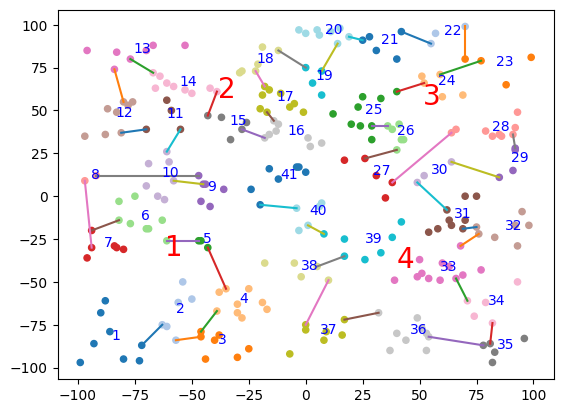

In [ ]:
if True:

    route = np.array(route_btw_clusters[n_hierarchies])
    sol_route = np.array(sol_route)
    for n in range(int(len(route_btw_clusters[n_hierarchies])/2)-1):
        plt.plot(route[2*n+1:2*(n+1)+1,0], route[2*n+1:2*(n+1)+1,1], '-')
    plt.scatter(sol_route[:,0], sol_route[:,1], c=sys2_labels[n_hierarchies][:], s=20)

    colors = 'rbk'
    sol_route_ex = sol_route_ex[1:]

    for H in range(len(sol_route_ex)):
        for n in range(len(sol_route_ex[H])):
            plt.text(sol_route_ex[H][n][0],sol_route_ex[H][n][1], str(n+1), fontsize = 10*(len(sol_route_ex)-H), color = colors[H])
    plt.show() 

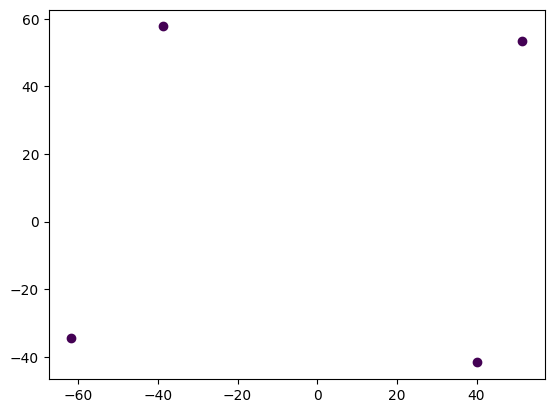

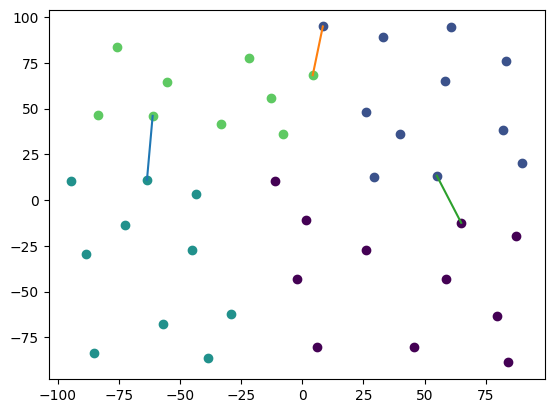

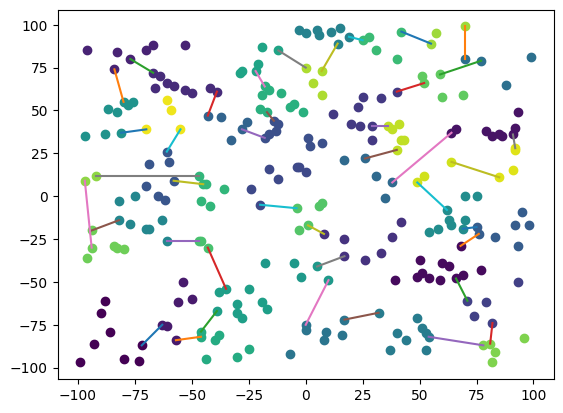

In [ ]:
for h in range(n_hierarchies+1):
    plt.figure()
    cmap = plt.cm.viridis
    route = np.array(route_btw_clusters[h])
    for n in range(int(len(route_btw_clusters[h])/2)-1):
        plt.plot(route[2*n+1:2*(n+1)+1,0], route[2*n+1:2*(n+1)+1,1], '-')
    num_iters = len(sys2_clusters[n_hierarchies - h])
    colors = [cmap(i/num_iters) for i in range(num_iters)]
    iter = 0
    for k in range(len(sys2_clusters[n_hierarchies - h])):
        plt.scatter(sys2_clusters[n_hierarchies - h][k][:,0], sys2_clusters[n_hierarchies - h][k][:,1], color = colors[iter])
        iter+=1

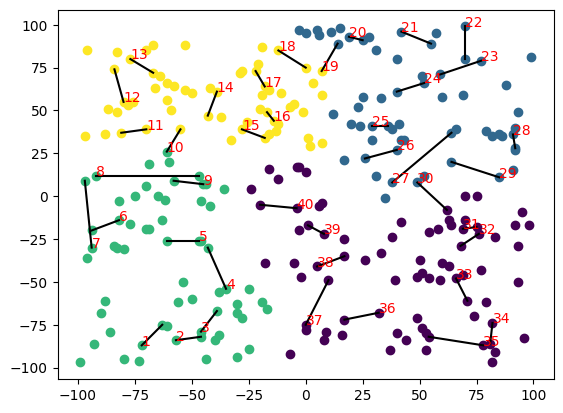

In [ ]:
colors_indices = np.zeros(len(sys2_clusters[0]))
cmap = plt.cm.viridis
for group_idx, group_indices in enumerate(sys2_clusters[1]):
    for center_idx in group_indices:  # Each index corresponds to a sublist in clusters[0]
        colors_indices[next(i for i, elem in enumerate(sys2_centers[0]) if np.array_equal(elem, center_idx))] = group_idx
colors = cmap(colors_indices/ max(colors_indices))
for idx, l in enumerate(sys2_clusters[0]):
    for point in l:
        plt.scatter(point[0], point[1], color = colors[idx])
for n in range(int(len(route_btw_clusters[2])/2)-1):
        plt.plot(route[2*n+1:2*(n+1)+1,0], route[2*n+1:2*(n+1)+1,1], '-', c='black')
        plt.text(route[2*n+1,0], route[2*n+1,1], str(n+1), fontsize = 10, color = 'red')

In [ ]:
from math import sin, cos, sqrt, atan2, radians
def compute_geo(p1,p2):
    R = 6373.0
    
    lat1 = radians(float(p1[0]))
    lon1 = radians(float(p1[1]))
    lat2 = radians(float(p2[0]))
    lon2 = radians(float(p2[1]))
    
    dlon = lon2 - lon1
    dlat = lat2 -lat1

    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2*atan2(sqrt(a),sqrt(1-a))
    dist = R*c
    return dist

In [ ]:
coord_geo == False
if coord_geo == True:
#     test = np.load("sys2clusters_" + str(x) + "/sol_table.npy", allow_pickle=True)
    for i in range(len(test)):
        print(i)
        for j in range(len(test[i])):
            geo_dist = 0
            li = test[i][j][1]
            for idx,elem in enumerate(li):
                thiscity = elem
                nextcity = li[(idx+1)%len(li)]
                geo_dist += compute_geo(thiscity, nextcity)
            test[i][j][2] = geo_dist 
            print(geo_dist)
        np.save("sys2clusters_" + str(x) + "/sol_table" ,test)    


mport pdb; pdb.set_trace()     

In [142]:
## Sangmin edited
GO = True   
if GO:
    with open("tsp" + x + "_pyconcorde.txt", "w") as f:
        solver = TSPSolver.from_data(X_coord, Y_coord, norm="EUC_2D")  
        solution = solver.solve()
        f.write( str(" ") + str('output') + str(" ") )
        f.write( str("solution found? ") + str(solution.found_tour) + str(" ") )
        f.write( str("Optimal value? ") + str(solution.optimal_value) + str(" ") )
        f.write( str(" ").join( str(node_idx+1) for node_idx in solution.tour) )
        f.write( str(" ") + str(solution.tour[0]+1) + str(" ") )

Problem Name: adcf8fd0fbb04944839742667f0f3c8f
Problem Type: TSP
Number of Nodes: 261
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2736
   0 Steps   Best: 2399   0.00 seconds
   1 Steps   Best: 2391   0.00 seconds
   3 Steps   Best: 2381   0.00 seconds
   6 Steps   Best: 2379   0.00 seconds
 130 Total Steps.
Best cycle length: 2379
Lin-Kernighan Running Time: 0.03
LK Initial Run: 2379.0
LK Run 0: 2383.0
LK Run from best tour: 2379.0
Time to find compression tour: 0.10 (seconds)
Set initial upperbound to 2379 (from tour)
Fractional Matching: 2283.5
Initial Running Time: 0.00 (seconds)
Basis Running Time: 0.00 (seconds)
Total fractional matching time: 0.00 (seconds)
Total Time for first_lp: 0.00 (seconds)
Setting upperbound to the initial bound: 2379.00
Loading lp...done in 0.00 seconds
LP has:  261 rows  429 columns  858 nonzeros
Dual opt returned after 0.00 seconds
Initial LP value: 2283.500000
Setting tol

need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed


0 cuts  0.0000 max violation  0.00 seconds
  Olaf 1: 6 cuts  0.6667 max violation  0.00 seconds
  Olaf 2: 9 cuts  1.3333 max violation  0.00 seconds
  Olaf 3: 4 cuts  1.3333 max violation  0.00 seconds
  Olaf 4: 5 cuts  1.3333 max violation  0.00 seconds
  Total Time in block_combs: 0.00
Found 56 block_combs in 0.00 seconds
  Add 56 cuts (Total 66), LP: 2335.375000 (0.00 seconds)
Found  4 exact subtours in 0.00 seconds
  Add  4 cuts (Total 69), LP: 2340.166667 (0.00 seconds)
Found 22 tighten_lp cuts (viol 1.0000) in 0.00 seconds
  Add 22 cuts (Total 73), LP: 2344.500000 (0.00 seconds)
Found 11 CLOSE tighten_lp cuts (viol 0.5000) in 0.00 seconds
  Add 11 cuts (Total 79), LP: 2348.250000 (0.00 seconds)
Found 17 double deckers (viol 3.0000) in 0.00 seconds
  Add 17 cuts (Total 83), LP: 2349.361111 (0.00 seconds)
Found  9 CLOSE double deckers (viol 0.7500) in 0.00 seconds
  Add  9 cuts (Total 80), LP: 2350.550000 (0.00 seconds)
Found  0 Handling Inequalities (viol -0.0000) in 0.00 seconds


 children
Prob Name: 28b173a0d
Prob ID: 0
Prob Parent ID: -1
Prob Bounds: (2376.578125, 2379.000000)
Prob Exact Lowerbound: 2376.578125
Read 55 LP fixed edges
Read LP full adj
Read LP exact dual values
Branch History
    Root Node
Done with read_probfile
Loading lp...done in 0.00 seconds
LP has:  421 rows  590 columns  3634 nonzeros
Dual opt returned after 0.00 seconds
Initial LP value: 2376.578125
Creating child 0 of LP 0: Set Edge (211, 212) to 0
Branch Edge (211,212), to value 0
CCtsp_init_edgegenerator (0)
CCtsp_generate_edges (20783)
Time for Add edges: 0.00 seconds (0.00 total in 1 calls)
(SPARSE) 0 edges added, penalty -0.000000, val 2377.000000
New (node) lower bound: 2377.000000
Prob Name: 28b173a0d
Prob ID: 0
Prob Parent ID: -1
Prob Bounds: (2376.578125, 2379.000000)
Prob Exact Lowerbound: 2376.578125
Read 55 LP fixed edges
Read LP full adj
Read LP exact dual values
Branch History
    Root Node
Done with read_probfile
Loading lp...done in 0.00 seconds
LP has:  421 rows  590 c

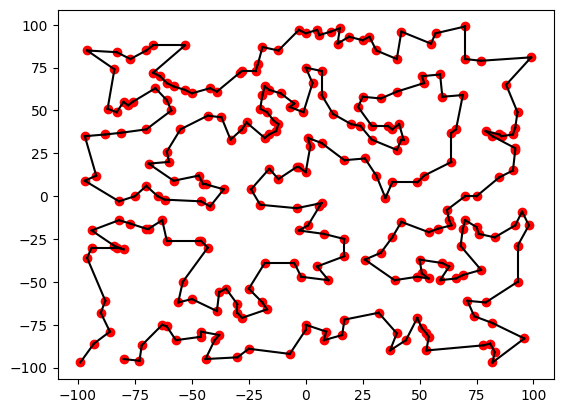

In [128]:
for idx, position in enumerate(solution.tour):
    plt.scatter(X_coord[position], Y_coord[position], c = 'red')
    if idx != len(solution.tour)-1:
        plt.plot([X_coord[position], X_coord[solution.tour[idx+1]]], [Y_coord[position], Y_coord[solution.tour[idx+1]]], c = 'black')

In [ ]:
GO = False
if GO:
    num_samples = 10000
    set_nodes_coord = np.random.random([num_samples, n_clusters, 2])
    with open("tsp" + str(n_clusters) + "_pr1002.txt", "w") as f:
        solver = TSPSolver.from_data(centers[:,0], centers[:,1], norm="EUC_2D")  
        solution = solver.solve()
        f.write( " ".join( str(x)+str(" ")+str(y) for x,y in centers) )
        f.write( str(" ") + str('output') + str(" ") )
        f.write( str(" ").join( str(node_idx+1) for node_idx in solution.tour) )
        f.write( str(" ") + str(solution.tour[0]+1) + str(" ") )
        